In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from osgeo import gdal

In [3]:
import numpy as np

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, Resize, Normalize, ToTensor, CenterCrop, Pad
from torch.autograd import Variable
from torch import LongTensor, Tensor

In [5]:
import numpy as np

In [6]:
from PIL import Image

In [7]:
file = '/home/kruglov/projects/cit/grayA.tif'

In [8]:
dataset = gdal.Open(file, gdal.GA_ReadOnly)

In [9]:
print ('Драйвер: ', dataset.GetDriver().ShortName,'/', \
      dataset.GetDriver().LongName)
print ('Размер ',dataset.RasterXSize,'x',dataset.RasterYSize, \
      'x',dataset.RasterCount)
print ('Проекция ',dataset.GetProjection())
geotransform = dataset.GetGeoTransform()
if not geotransform is None:
    print ('Начало координат (',geotransform[0], ',',geotransform[3],')')
    print ('Размер пиксела = (',geotransform[1], ',',geotransform[5],')')


Драйвер:  GTiff / GeoTIFF
Размер  7570 x 8313 x 1
Проекция  PROJCS["WGS 84 / UTM zone 38N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",45],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32638"]]
Начало координат ( 566451.160957676 , 4794865.844518707 )
Размер пиксела = ( 0.075 , -0.075 )


In [10]:
band = dataset.GetRasterBand(1)

In [11]:
band

<osgeo.gdal.Band; proxy of <Swig Object of type 'GDALRasterBandShadow *' at 0x7fd4cf6b6480> >

In [19]:
band.XSize, band.YSize

(7570, 8313)

In [20]:
print ('Тип данных',gdal.GetDataTypeName(band.DataType))
min = band.GetMinimum()
max = band.GetMaximum()
if min is not None and max is not None:
    (min,max) = ComputeRasterMinMax(1)
    print ('Min=%.3f, Max=%.3f' % (min,max))
if band.GetOverviewCount() > 0:
    print ('Канал содержит ', band.GetOverviewCount(), \
    ' обзорных изображений.')
if not band.GetRasterColorTable() is None:
    print ('Канал содержит таблицу цветов с ', \
    band.GetRasterColorTable().GetCount(), ' записями.')

Тип данных Byte


In [21]:
scanline = band.ReadRaster( 2000, 2000, 1000, 1000, \
                             1000, 1000, gdal.GDT_Float32 )

In [22]:
import struct

tuple_of_floats = struct.unpack('f' * 1000 * 1000, scanline)

In [23]:
img = np.array(list(tuple_of_floats)).reshape(1000, 1000)

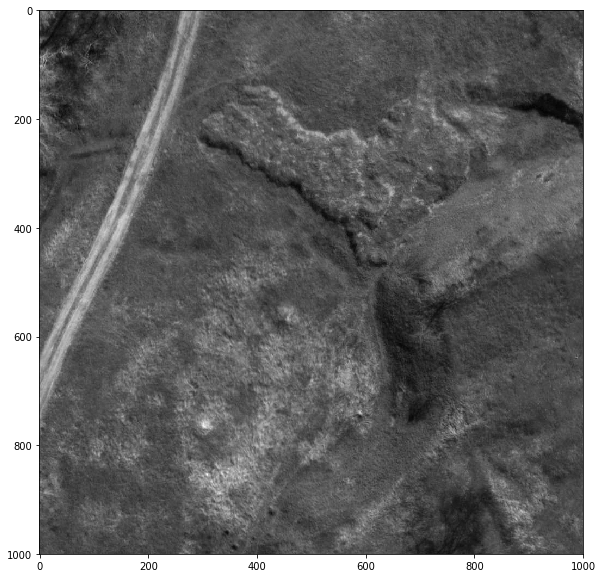

In [24]:
plt.figure(figsize= (10, 10))
plt.imshow(img, cmap= 'gray');

In [25]:
cars_img = Image.open('/home/kruglov/projects/cit/grayA_cars_annotated.png')

In [26]:
cars_arr = np.array(cars_img)

In [27]:
cars_arr.shape

(8313, 7570, 2)

In [28]:
cars_arr[:,:,1].sum() / 255

22.0

In [29]:
mask = cars_arr[:,:,1] == 255

grid = np.mgrid[0:cars_arr.shape[0],0:cars_arr.shape[1]]

coords = grid[:,mask][:,0]

In [30]:
coords.shape

(2,)

In [31]:
scanline = band.ReadRaster( int(coords[1]-50), int(coords[0]-50), 100, 100, \
                             100, 100, gdal.GDT_Float32 )

In [32]:
tuple_of_floats = struct.unpack('f' * 100 * 100, scanline)

In [33]:
img = np.array(list(tuple_of_floats)).reshape(100, 100)

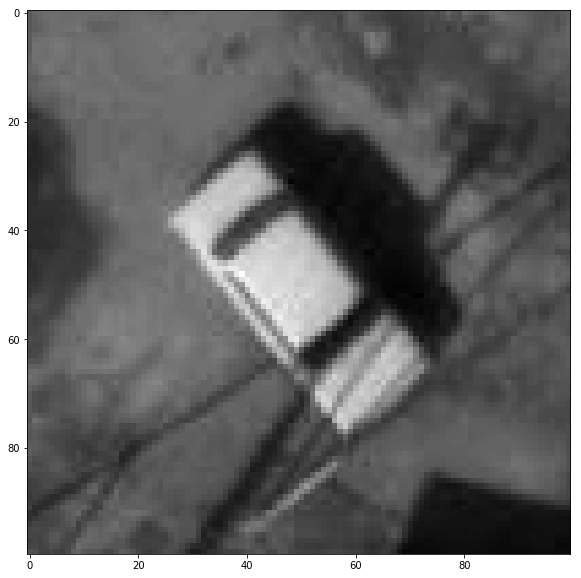

In [34]:
plt.figure(figsize= (10, 10))
plt.imshow(img, cmap= 'gray');

In [7]:
from math import ceil

In [8]:
import struct

In [9]:
class CITDataset(Dataset):
    
    def __init__(self, paths, transform= None):
        # parameters
        self.width = self.height = 224
        
        ds = gdal.Open(paths['band'], gdal.GA_ReadOnly)
        print ('Размер ',ds.RasterXSize,'x',ds.RasterYSize, \
              'x',ds.RasterCount)
        self.band = ds.GetRasterBand(1)
        print ('Тип данных: ',gdal.GetDataTypeName(self.band.DataType))
        print ('Размер: ', self.band.XSize, self.band.YSize)
        
        self.pos = self.get_coords(paths['pos'])
        self.neg = self.get_coords(paths['neg'])
        self.coords = self.pos


    def __getitem__(self, index):
        coords = self.coords[:,index]
        width = self.width
        height = self.height
        scanline = self.band.ReadRaster(int(coords[1]-ceil(width / 2)), \
                                        int(coords[0]-ceil(height / 2)), \
                                        width, height, \
                                        width, height, gdal.GDT_Float32 )

        tuple_of_floats = struct.unpack('f' * width * height, scanline)
        img = np.array(list(tuple_of_floats)).reshape(height, width)
        
        if self.transform is not None:
            img = self.transform(img)
        
        return img


    def __len__(self):
        return len(self.pos) + len(self.neg)
    
   
    def read_raster(self):
        scanline = self.band.ReadRaster( 2000, 2000, 1000, 1000, \
                             1000, 1000, gdal.GDT_Float32 )
    
    def get_coords(self, path):
        img = np.array(Image.open(path))
        mask = img[:,:,1] == 255
        grid = np.mgrid[0:img.shape[0],0:img.shape[1]]
        coords = grid[:,mask]
        
        return coords

In [10]:
paths = {
        'band':'/home/kruglov/projects/cit/grayA.tif',
        'pos': '/home/kruglov/projects/cit/grayA_cars_annotated.png',
        'neg': '/home/kruglov/projects/cit/grayA_neg_annotated.png'
}

In [53]:
ds = CITDataset(paths)

Размер  7570 x 8313 x 1
Тип данных:  Byte
Размер:  7570 8313


In [54]:
ds.band

<osgeo.gdal.Band; proxy of <Swig Object of type 'GDALRasterBandShadow *' at 0x7fa6c90bc480> >

In [55]:
ds.coords[:,0]

array([1527, 6938])

In [66]:
ds.band.XSize, ds.band.YSize

(7570, 8313)

In [ ]:
ds.read_raster()

In [ ]:
scanline = ds.band.ReadRaster( 2000, 2000, 1000, 1000, \
                             1000, 1000, gdal.GDT_Float32 )

In [ ]:
inputs = ds.__getitem__(0)

In [ ]:
1 == 1